# LNN on Kepler

This notebook studies learning the discrete lagrangian the Kepler system in a self-contained and continuous manner using the various modules implemented in the project repo.

In [1]:
# General imports
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import jaxopt
from jax.experimental.ode import odeint
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

from jax.config import config
config.update("jax_enable_x64", True)

# import our modules
from model_new_loss import NNLearner
from dataset_generator import TrajectoryDataset

## System configuration

In [2]:
# Set system
from systems.system_Kepler_cartes import Kepler_lagrangian_cartes, solve_lagrangian_autograd, hamiltonian_Kepler_cart,f_autograd
from jax import jit
target = 'xdot'          # 'tripple' (more available in the main file)

N = 50
N_simul_after_learning = 200
num_epochs = 100000

stepsize = 0.1
test_every_choice = 10

dof = 2
system_lagrangian = Kepler_lagrangian_cartes

x0 = np.array([1., 0., 0., .6], dtype=np.float64) 
x0_test = np.array([1.1, -0.01, 0., 0.6], dtype=np.float64)  #for test
q0_train, v0_train = jnp.split(x0, 2)
p0_train = jax.grad(system_lagrangian,argnums = 1)(q0_train, v0_train)

q0_test, v0_test = jnp.split(x0_test, 2)
p0_test = jax.grad(system_lagrangian,argnums = 1)(q0_test, v0_test)


### Generate trajectories using solvers to be used for dataset generation later

In [3]:
from SVI_integrators import SVI_solver_TQs
def discrete_lagrangian_orig(qk, qk_1, h):
    return h*system_lagrangian((qk+qk_1)/2,(qk_1-qk)/h)


from utils import f2c_trajectory

proportion_f2c = int(stepsize/0.001)
train_trajectory = f2c_trajectory(proportion_f2c, stepsize, N, SVI_solver_TQs, discrete_lagrangian_orig, q0_train, p0_train)
test_trajectory = f2c_trajectory(proportion_f2c, stepsize, N, SVI_solver_TQs, discrete_lagrangian_orig, q0_test, p0_test)

train_trajectory_check,_ = SVI_solver_TQs(discrete_lagrangian_orig, stepsize, q0_train, p0_train, N) 
test_trajectory_check,_= SVI_solver_TQs(discrete_lagrangian_orig, stepsize, q0_test, p0_test, N) 

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 66.19it/s]


Text(0.5, 1.0, 'comparing how different the test and train trajs are')

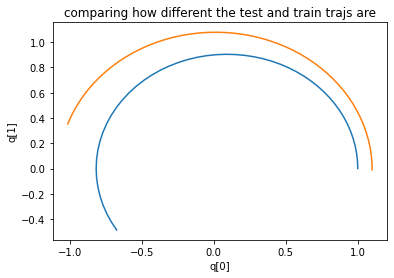

In [4]:
plt.plot(train_trajectory[:,0], train_trajectory[:,1], label="train traj")
plt.plot(test_trajectory[:,0], test_trajectory[:,1], label="test traj")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('comparing how different the test and train trajs are')

## Dataset generation from trajectories

In other words map the analytically generated trajectory into a dataset of (input, target) observation tuples to be used for training our model. Note there are different (input, target) observations generated based on the `mode` parameter of the `TrajectoryDataset` instantiation.

The `TrajectoryDataset` extends `torch.utils.data.Dataset` and hence has the same behaviour (API) with some additional attributes. Supports index based subscript access to the dataset. 

In [5]:
eom = partial(f_autograd, system_lagrangian)

train_dataset = TrajectoryDataset(input_trajectory=train_trajectory, 
    mode="xdot", eom=eom, lagrangian=system_lagrangian, np_mode=True)
test_dataset = TrajectoryDataset(input_trajectory=test_trajectory, 
    mode="xdot", eom=eom, lagrangian=system_lagrangian, np_mode=True)

len(train_dataset)

51

## Instantiating and fitting a neural network model

In the cell below we specify the `NNLearner` which involves specifying: the functional model (architecture of the network), the optimiser (and any hyperparameters it will have, the train and test dataset, the loss function to be used, and any additional hyperparameters.

To specify the functional model modify the arguments of the `stax.serial` function below, which will be passed into the `NNLearner` via the `stax` argument.

Specification of the optimiser is done via two arguments to the `NNLearner`: the `optimizer` str argument which expects the name of the optimiser to be used (currently only "adam" and "sgd"), the other argument is the `optimizer_parameters` which are any additional hyperparameters passed into the internal `optimisers.<adam/sgd>` instantiation. 

In [6]:
from jax.example_libraries import stax
from jax.example_libraries import optimizers

stax_nn = stax.serial(
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(1),
        )
optimizer_parameters = lambda t: jnp.select([t < 1000, t > 2000, t > 3000, t > 4000, t > 5000, t > 8000, t > 10000, t > 12000, t > 18000, t > 25000], [3e-3, 3e-4, 3e-5, 3e-6, 3e-7, 3e-7, 3e-7, 3e-8, 3e-8, 3e-8])
optimizer_parameters = lambda t: jnp.select([t < 1000, t > 2000, t > 3000, t > 4000, t > 5000, t > 8000, t > 10000, t > 12000, t > 18000, t > 25000, t>70000], [3e-3, 3e-4, 3e-5, 3e-6, 3e-7, 3e-7, 3e-7, 3e-8, 3e-8, 3e-6, 3e-8])


def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

model = NNLearner(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    loss="xdot", # standard LNN
    h=stepsize,
    stax=stax_nn,
    dof=dof,
    input_shape=4,
    optimizer="adam",
    nn_output_modifier=equation_of_motion, 
    optimizer_parameters = optimizer_parameters
)

params, train_losses_record, test_losses_record = model.fit_lnn( 
    num_epochs=num_epochs, test_every=test_every_choice
)


## Learning the lagrangian


Epochs progress: 100%|█████████████████| 100000/100000 [12:34<00:00, 132.62it/s]


### Plot the training and test loss over the epochs (x ticks according to recorded steps)

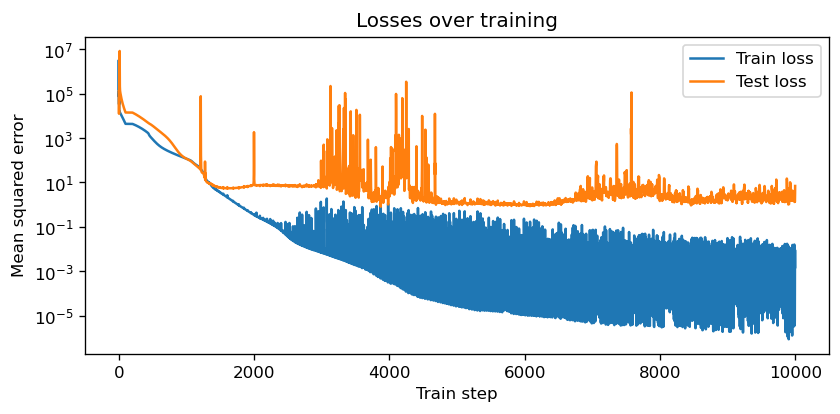

In [7]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses_record, label='Train loss')
plt.plot(test_losses_record, label='Test loss')
plt.yscale('log')

plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

# Simulating (trying to recreate) the train trajectory using the learnt Lagrangian and predicting future behaviour

In [8]:
from SVI_integrators import SVI_solver_TQs

def discrete_lagrangian_based_on_NN(qk,qk_1,h): #' here we have learnt Lc so we need to make a discrete approx of it (discretize it)
        return h*model.learned_lagrangian(params)((qk+qk_1)/2,(qk_1-qk)/h)

First we try to recreate the train trajectory which is N steps long

100%|███████████████████████████████████████████| 49/49 [00:53<00:00,  1.09s/it]


Text(0, 0.5, 'q[1]')

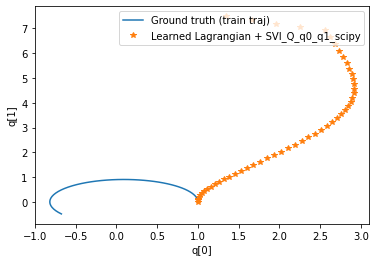

In [9]:
from SVI_integrators import  SVI_solver_Q_noinitstep_scipyroot
q0=train_trajectory[0,0:dof]
q1 = train_trajectory[1,0:dof]

q_model_SVI_Q_q0_q1_scipy, times_SVI_Q_q0_q1_scipy = SVI_solver_Q_noinitstep_scipyroot(discrete_lagrangian_based_on_NN, stepsize, q0, q1, N,"hybr")
q_model_SVI_Q_q0_q1_scipy2 =q_model_SVI_Q_q0_q1_scipy.T
plt.plot(train_trajectory[:,0],train_trajectory[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,0],q_model_SVI_Q_q0_q1_scipy2[:,1], "*",label="Learned Lagrangian + SVI_Q_q0_q1_scipy")

plt.legend(loc="upper right")
plt.xlabel('q[0]')
plt.ylabel('q[1]')

Text(0.5, 1.0, 'q[0]  evolution, recreating the train trajectory')

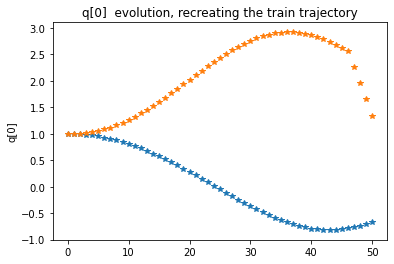

In [10]:
plt.plot(train_trajectory[:,0], '*',label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,0],'*', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[0]')
plt.title('q[0]  evolution, recreating the train trajectory')

Text(0.5, 1.0, ' q[1] evolution, recreating the train trajectory')

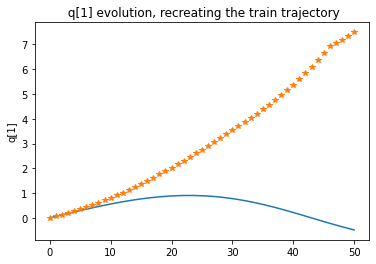

In [11]:
plt.plot(train_trajectory[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,1], '*',label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[1]')
plt.title(' q[1] evolution, recreating the train trajectory')

Nex we try to recreate the train trajectory and also predict for additional steps with a total stels of N_simul_after_learning 

100%|█████████████████████████████████████████| 199/199 [04:19<00:00,  1.30s/it]


Text(0.5, 1.0, 'q[0] vs q[1] evolution, recreating the train trajectory AND including a further prediction')

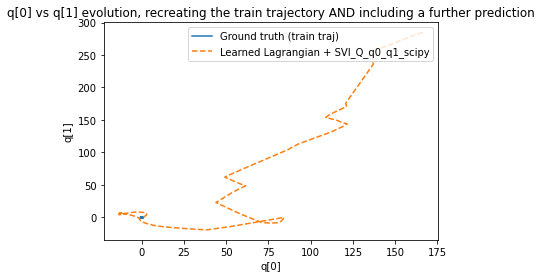

In [12]:
from SVI_integrators import  SVI_solver_Q_noinitstep_scipyroot
q0=train_trajectory[0,0:dof]
q1 = train_trajectory[1,0:dof]
N_simul_after_learning=200
train_trajectory_extra = f2c_trajectory(proportion_f2c, stepsize, N_simul_after_learning, SVI_solver_TQs, discrete_lagrangian_orig, q0_train, p0_train)

q_model_SVI_Q_q0_q1_scipy_extra, times_SVI_Q_q0_q1_scipy = SVI_solver_Q_noinitstep_scipyroot(discrete_lagrangian_based_on_NN, stepsize, q0, q1, N_simul_after_learning,"hybr")
q_model_SVI_Q_q0_q1_scipy_extra2 =q_model_SVI_Q_q0_q1_scipy_extra.T

#plot
plt.plot(train_trajectory_extra[:,0],train_trajectory_extra[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,0],q_model_SVI_Q_q0_q1_scipy_extra2[:,1],'--', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.legend(loc="upper right")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('q[0] vs q[1] evolution, recreating the train trajectory AND including a further prediction')

Text(0.5, 1.0, 'q[0] evolution, recreating the train trajectory AND including a further prediction')

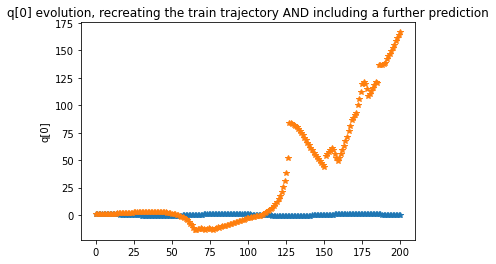

In [13]:
plt.plot(train_trajectory_extra[:,0], '*',label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,0],'*', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[0]')
plt.title('q[0] evolution, recreating the train trajectory AND including a further prediction')

Text(0.5, 1.0, 'q[1] evolution, recreating the train trajectory AND including a further prediction')

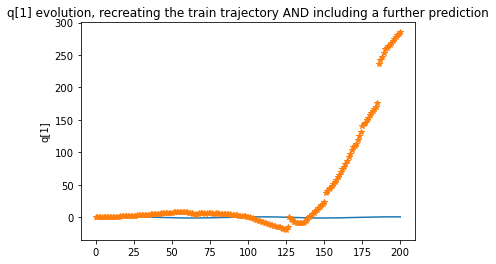

In [14]:
plt.plot(train_trajectory_extra[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,1], '*',label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[1]')
plt.title('q[1] evolution, recreating the train trajectory AND including a further prediction')

In [15]:
def Ldk(q_k, q_k1):
    return  stepsize*model.learned_lagrangian(params) ((q_k+q_k1)/2,(q_k1-q_k)/stepsize)
def D2Ld1k(q_1k, q_k): 
    return jax.grad(Ldk, argnums=1)(q_1k, q_k)
def D1Ldk(q_k, q_k1):  
    return jax.grad(Ldk, argnums=0)(q_k, q_k1)

result = np.zeros((dof,10-1))
mse  = np.zeros((1,10-1))

for k in range(0,10-1):

    q_1k = train_trajectory[k,0:dof]

    q_k = train_trajectory[k+1,0:dof]

    q_k1 = train_trajectory[k+2,0:dof]

    def D2_D1Ldk(q_k, q_k1):
        return jax.jacrev(D1Ldk, argnums=1)(q_k, q_k1)

    print(np.linalg.eigvals(D2_D1Ldk(q_k, q_k1)))

    result[:,k] = D2Ld1k(q_1k, q_k) + D1Ldk(q_k, q_k1)
    print(result[:,k])

[-2.90307702 -0.58037587]
[ 0.01275467 -0.00352149]
[-2.90112246 -0.57910189]
[ 0.01233981 -0.00246115]
[-2.89917836 -0.57771713]
[ 0.01192439 -0.00138677]
[-2.89726955 -0.57622871]
[ 0.01150877 -0.00030063]
[-2.89542242 -0.57464562]
[0.01109319 0.00079502]
[-2.89366472 -0.57297875]
[0.01067773 0.00189797]
[-2.89202535 -0.57124079]
[0.01026234 0.00300601]
[-2.89053409 -0.56944621]
[0.00984685 0.00411694]
[-2.88922123 -0.56761117]
[0.00943095 0.00522854]


In this example the symmetry I = p^T Mq with M = [0, 1/sqrt(2);-1/sqrt(2),0]. 

In the folowing tests when we refer to tajc computed from the learnt LD we use our recreation of the train trajectory and in the second part it plus an extended prediction on which we have not trained previously.


In [16]:
from jax import jit,grad
from SVI_funcs import SVI_funcs

def pm_calc_orig(q,v):
    return  jax.grad(system_lagrangian ,argnums = 1)(q,v)  
pm_calc_orig_jitted = jit(pm_calc_orig)

def learned_continuous_Lagrangian(q,qdot):   
    return model.learned_lagrangian(params)(q,qdot)

M_orig = np.zeros((2,2))
M_orig[0,1] = 1/np.sqrt(2)
M_orig[1,0] = -1/np.sqrt(2)

def symmetry_func_orig(q,p):
    return jnp.dot(p,M_orig@q)

def getting_symmetry_conservation_test(q_ground_truth,q_predicted_using_learntLd,number_steps,v0_start,naming_info):
    orig_traj = q_ground_truth[:,0:dof].T
    traj_from_learnt_Ld = q_predicted_using_learntLd[:,0:dof].T

    p_Lorig_qlearnt_vlearntCD = np.zeros((dof,number_steps))
    p_Lorig_qlearnt_vlearntCD[:,0] = pm_calc_orig_jitted(traj_from_learnt_Ld[:,0],v0_start)  
    for k in range(1, number_steps): 
        vk =  (-traj_from_learnt_Ld[:,k-1]+traj_from_learnt_Ld[:,k+1])/2/stepsize
        qk = traj_from_learnt_Ld[:,k]
        p_Lorig_qlearnt_vlearntCD[:,k] = pm_calc_orig_jitted(qk,vk)
    
    
    I_Lorig_qlearnt_vlearntCD = np.zeros((number_steps))
    for k in range(0, number_steps): 
        I_Lorig_qlearnt_vlearntCD[k] = symmetry_func_orig( traj_from_learnt_Ld[:,k],p_Lorig_qlearnt_vlearntCD[:,k])

    

    return I_Lorig_qlearnt_vlearntCD




Testing first with the recreated traintrajectory

In [17]:
I_Lorig_qlearnt_vlearntCD = getting_symmetry_conservation_test(train_trajectory,q_model_SVI_Q_q0_q1_scipy2,N,v0_train,'based on recreating the train trajectory')


Text(0.5, 1.0, 'I ERROR  recreaing the train trajectory')

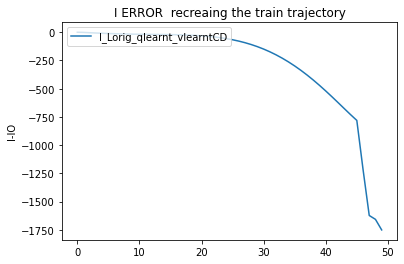

In [18]:
plt.plot(I_Lorig_qlearnt_vlearntCD-I_Lorig_qlearnt_vlearntCD[0]*np.ones((N)), label="I_Lorig_qlearnt_vlearntCD")

plt.legend(loc="upper left")
plt.ylabel('I-IO')
plt.title('I ERROR  recreaing the train trajectory')


    Now with extra predctions

In [19]:
I_Lorig_qlearnt_vlearntCD_extra = getting_symmetry_conservation_test(train_trajectory_extra,q_model_SVI_Q_q0_q1_scipy_extra2,N_simul_after_learning,v0_train,'based on recreating the train trajectory and predicting its extension')


Text(0.5, 1.0, 'I ERROR  recreaing the train trajectory AND PREDICTION')

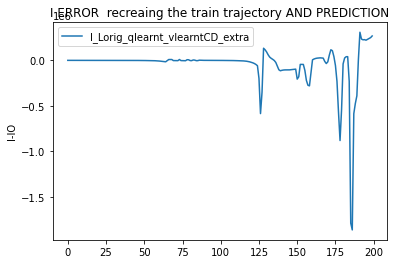

In [20]:
plt.plot(I_Lorig_qlearnt_vlearntCD_extra-I_Lorig_qlearnt_vlearntCD_extra[0]*np.ones((N_simul_after_learning)), label="I_Lorig_qlearnt_vlearntCD_extra")

plt.legend(loc="upper left")
plt.ylabel('I-IO')
plt.title('I ERROR  recreaing the train trajectory AND PREDICTION')

In [21]:
from Hamiltonian_Identification import *
def learned_continuous_Lagrangian(q,qdot):  
    return model.learned_lagrangian(params)(q,qdot)
    
H_ref = Hamiltonian_from_L(system_lagrangian)
Hlearnt    = Hamiltonian_from_L(learned_continuous_Lagrangian)
def H_simulation_tests(q_ground_truth,q_predicted_using_learntLd,number_steps,v0_start):
    #v0_start = v0_train
    orig_traj = q_ground_truth[:,0:dof].T
    traj_from_learnt_Ld = q_predicted_using_learntLd[:,0:dof].T

    Horig_qlearnt_vlearntCD = np.zeros((number_steps))
    Horig_qlearnt_vlearntCD[0] = H_ref( traj_from_learnt_Ld[:,0], v0_start)
    for k in range(1, number_steps): 
        vk =  (-traj_from_learnt_Ld[:,k-1]+traj_from_learnt_Ld[:,k+1])/2/stepsize
        qk = traj_from_learnt_Ld[:,k]
        Horig_qlearnt_vlearntCD[k] = H_ref( qk, vk)
    

    return  Horig_qlearnt_vlearntCD
    



Text(0.5, 1.0, 'H ERROR for recreated train trajectory ')

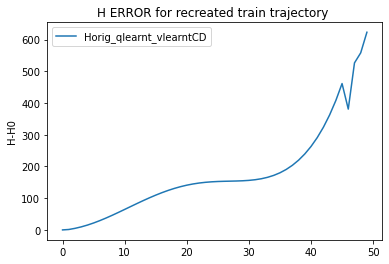

In [22]:
Horig_qlearnt_vlearntCD =  H_simulation_tests(train_trajectory,q_model_SVI_Q_q0_q1_scipy2,N,v0_train)
plt.plot(Horig_qlearnt_vlearntCD- Horig_qlearnt_vlearntCD[0]*jnp.ones((N)), label="Horig_qlearnt_vlearntCD")

plt.legend(loc="upper left")
plt.ylabel('H-H0')
plt.title('H ERROR for recreated train trajectory ')

Now with some prediction

In [23]:
Horig_qlearnt_vlearntCD_extra = H_simulation_tests(train_trajectory_extra,q_model_SVI_Q_q0_q1_scipy_extra2,N_simul_after_learning,v0_train)


Text(0.5, 1.0, 'H ERROR comparison for recreated train trajectory AND a prediction')

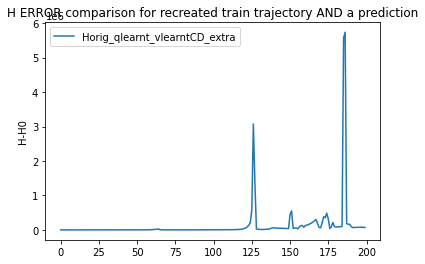

In [24]:
plt.plot(Horig_qlearnt_vlearntCD_extra- Horig_qlearnt_vlearntCD_extra[0]*jnp.ones((N_simul_after_learning)),label="Horig_qlearnt_vlearntCD_extra")
plt.legend(loc="upper left")
plt.ylabel('H-H0')
plt.title('H ERROR comparison for recreated train trajectory AND a prediction')

In [26]:
import os
import pickle
from pathlib import Path

approach = "LNN" # LNN, DLNN, or SymDLNN
group = "C" # A, B, C, D, or E
path_to_results = os.path.join("results_final", group, approach)
Path(path_to_results).mkdir(parents=True, exist_ok=True)

pkl_filename = os.path.join(path_to_results, "results_dict.pkl")

# LNN version kepler
dict_to_save = {
    "train_trajectory": train_trajectory,
    "test_trajectory": test_trajectory,
    "train_losses_record": train_losses_record,
    "test_losses_record": test_losses_record,
    "q_model_SVI_Q_q0_q1_scipy": q_model_SVI_Q_q0_q1_scipy,
    "q_model_SVI_Q_q0_q1_scipy2": q_model_SVI_Q_q0_q1_scipy2,
    "train_trajectory_extra": train_trajectory_extra,
    "q_model_SVI_Q_q0_q1_scipy_extra": q_model_SVI_Q_q0_q1_scipy_extra,
    "q_model_SVI_Q_q0_q1_scipy_extra2": q_model_SVI_Q_q0_q1_scipy_extra2,
    "I_Lorig_qlearnt_vlearntCD_extra": I_Lorig_qlearnt_vlearntCD_extra,
    "Horig_qlearnt_vlearntCD_extra": Horig_qlearnt_vlearntCD_extra, 
}

with open(pkl_filename, "wb") as fh:
    pickle.dump(dict_to_save, fh)
